In [1]:
%%sh
# Small cleanup for reproducibility
rm -rf /tmp/tut_plotting/

In [2]:
import dds
dds.set_store("local", internal_dir="/tmp/tut_plotting/dds_internal/", data_dir="/tmp/tut_plotting/dds_data/")
# import logging
# logging.basicConfig(
#   format="%(asctime)s %(name)s %(levelname)s %(message)s", level=logging.DEBUG
# )

## Plotting network dependencies with DDS

`DDS` allows you to track and display the dependencies between data objects that get tracked with a name.

> Reminder:
>
> In order to use the plotting facilities, you must have the `pydotplus` package installed, as well as its own dependency (Graphviz).


Exporting the function graph without running the actual function is done with the `dds.eval` function:

```py

def my_function(arg1, arg2, ...): ...

dds.eval(fun,
         arg1,
         arg2,
         ...
         dds_export_graph="path_to_png_file",
         dds_extra_debug=True,
         dds_stages=["analysis"])
```

With this call, the function will not be executed. Instead, all its code dependencies will be resolved and analyzed.

Here is an example that leverages the integration with Jupyter. This shows a single function the output of which is registered
under the path `/f`.

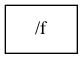

In [3]:
import dds
from IPython.display import Image

# A small utility to plot a function without executing it:
def plot_function(fun) -> Image:
    f_name = f"/tmp/tut_plotting/dds_plot_{str(id(fun))}.png"
    dds.eval(fun, dds_export_graph=f_name, dds_extra_debug=True, dds_stages=["analysis"])
    return Image(f_name)

@dds.data_function("/f")
def f(): return 1

plot_function(f)

How to show multiple independent functions? Multiple DDS functions can be packaged under a single function.
In most cases, DDS can infer that they are independent of each other and will show them 
separately. Here is the examle of two independent functions `f1` and `f2`:

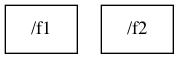

In [4]:
@dds.data_function("/f1")
def ex1a(): return 1

@dds.data_function("/f2")
def ex1b(): return 2

def ex1():
    ex1a()
    ex1b()

plot_function(ex1)

**Data dependencies**

The DDS function `f1` depends on the DDS function `f2`. This is tracked with a solid line. The graph shows the outputs first at the top, and the dependencies at the bottom.

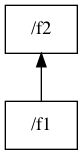

In [5]:
@dds.data_function("/f1")
def ex2a(i): return 2 + i

@dds.data_function("/f2")
def ex2b(): return 2 + ex2a(1)

def ex2():
    ex2b()

plot_function(ex2)

**Implicit dependencies**

In the function `f`, the output of the DDS function `f1` is passed as an argument to the DDS function `f2`. This is a case of implicit dependency: DDS has infered that the calculation of `f2` is dependent on the calculation of `f1` (through potentially other steps in the function `f`). It indicates that through dashed arrows.

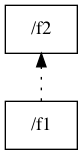

In [6]:
@dds.data_function("/f1")
def f1(): return 2

@dds.data_function("/f2")
def f2(i): return 2 + i

def f():
    res1 = f1()
    my_var = res1 * 2
    f2(my_var)

plot_function(f)

Note that only the most significant dependencies are represented. In this case, `f1` is evaluated twice: before and after `f2`. Because `f2` implicitly depends on `f1` but not the opposite, only the first call to `f1` is taken into account.

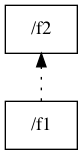

In [7]:
@dds.data_function("/f1")
def ex4a(): return 2

@dds.data_function("/f2")
def ex4b(i): return 2 + i

def ex4():
    res1 = ex4a()
    ex4b(res1)
    ex4a()

plot_function(ex4)

The functions call can be arbitrarily nested. In this case, because `f1` is already a dependency of `f3`, it is not brought further even if it is called in `f`.

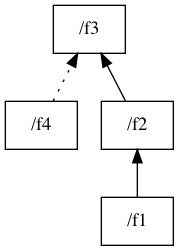

In [8]:
@dds.data_function("/f1")
def f1(): return 2 

@dds.data_function("/f2")
def f2(): return 2 + f1()

@dds.data_function("/f3")
def f3(i): return 1 + f2()

@dds.data_function("/f4")
def f4(): return 1


def f():
    x = f4()
    f3(x)
    f1()

plot_function(f)

Note that in general when the functions take arguments, DDS cannot infer independencies. In this case, `f3` and `f5` could be independent. However, because they share an argument call through `x`, this argument could be modified during the call and as such, no further independence can be assumed.

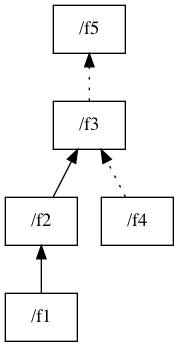

In [9]:
@dds.data_function("/f5")
def f5(i): return 1 + i

def f():
    f1()
    x = f4()
    f3(x)
    f5(x)
    f1()

plot_function(f)

## Indirect references

Indirect references (the `load` function) refers directly to the content without having to call the function itself.

This is plotted as usual. Note that the link is in dashed lines, indicating that the call is not direct.

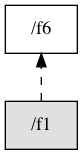

In [10]:
# Ensure that the path exists
f1()

@dds.data_function("/f6")
def f6():
    return dds.load("/f1")

plot_function(f6)

Here is a final example that combines all the dependencies.

Note that `dds` does not automatically sort the ordering for you. When a single function call both calls a path through its function definition and through an indirect reference, the indirect reference must happen _after_ the call to the direct function. In the example of the function `f` below, the call to `f6` must happen _after_ calling `f2` or `f3`. Otherwise, `f6` depends on `f1`, but `f1` will be calculated in the _future_. `dds` prevents such circular dependencies.

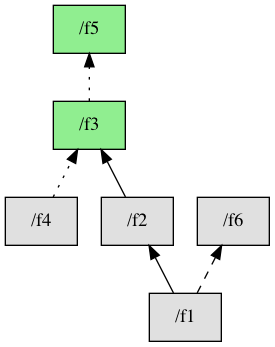

In [15]:
def f():
    x = f4()
    f3(x)
    f5(x)
    f6()

plot_function(f)